# Long Live Transformers!
> In this blog post, we will understand the building blocks of transformers and how they changed NLP.

- toc: true
- badges: false
- comments: true
- categories: [python, pytorch, attention, transformers]
- image: images/long-live-transformers-banner.png


---

I would like to thank [Deep Gandhi](https://github.com/deep1401) and [Pranjal Chitale](https://github.com/PranjalChitale) for reviewing this blog and providing valuable feedback.

---

This post assumes that you have a basic understanding of Neural Networks, specifically Recurrent Neural Networks (RNNs) and Bahdanau's attention mechanism. If you are new to the above-mentioned concepts or you'd like to brush up, I would highly recommend reading [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and Attentional Interfaces section from [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).


Sequence-to-sequence (Seq2Seq) models have achieved a lot of success in various tasks such as machine translation, text summarization, question answering, etc. RNNs were the primary choice for seq2seq as they are useful for learning variable-length sequential data, but their sequential nature inherently inhibits parallelization. Long Short Term Memory (LSTMs) and Gated Recurrent Units (GRUs) widely dominated the RNN landscape. Although RNNs are good for capturing temporal dependencies, but they fail to preserve the complete context for long sequences. Attention mechanism overcame this drawback by providing us the ability to focus on different parts of encoded sequences during the decoding stage, thereby allowing the context to be preserved from beginning to end. Furthermore, attention between encoder and decoder has helped improve the performance of neural machine translation. Is there a way we can use attention for representations and parallelize all the computations without using RNNs?


# Transformer

The Transformer is a deep learning language model that completely relies on attention mechanisms, specifically self-attention, to find relationships (global dependencies) between input and output. The Transformers have revolutionized the field of natural language processing and are the de facto standard for various language modeling tasks. The Transformers have been the backbone of state-of-the-art language models such as BERT, GPT, etc. Additionally, they are also being applied to computer vision and speech-related tasks. Now that we have got the idea of what the transformer is trying to achieve, so let's dive deeper into the basic building blocks of this transformer architecture.


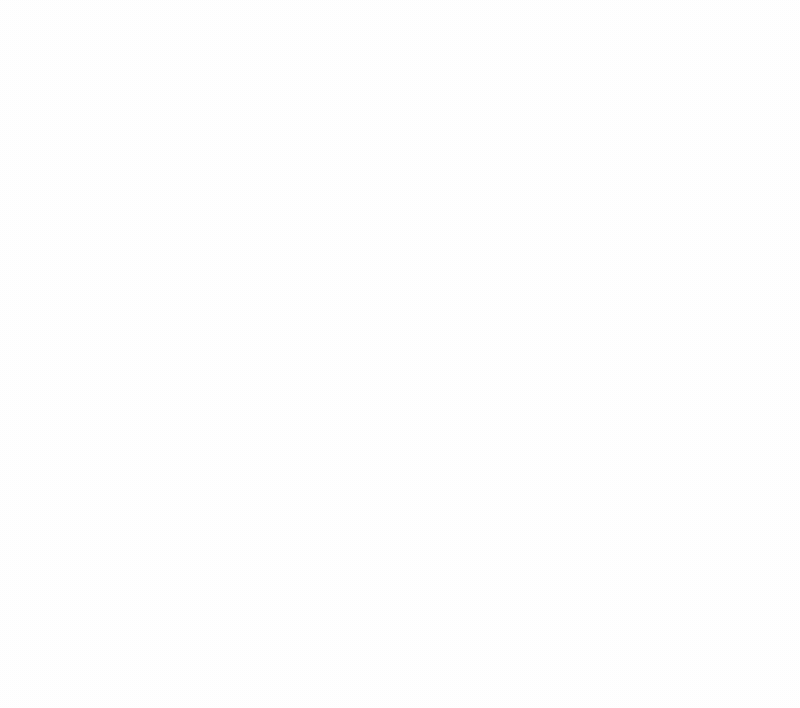


<center>Visual overview of transformer (image source: https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)</center>


## Model Architecture

The Transformer also follows the encoder-decoder architecture, same as the other neural transduction models. The encoder encodes an input sequence to a sequence of continuous representations, which the decoder uses to generate output sequence each time step during decoding. Thus, the decoding stage can be thought of as autoregressive language modeling, where the decoder finds the output sequence that is most probable conditioned on the input sequence. Mathematically, it can be formulated as follows:

$$
P_{\theta}(y | x) = \prod_{t=1}^{T} P_{\theta}(y_t | y_{<t}, x)
$$

where $x$ and $y$ denote the input and output sequence, $\theta$ denote the model parameters, and $t$ denote time step in the decoding stage.


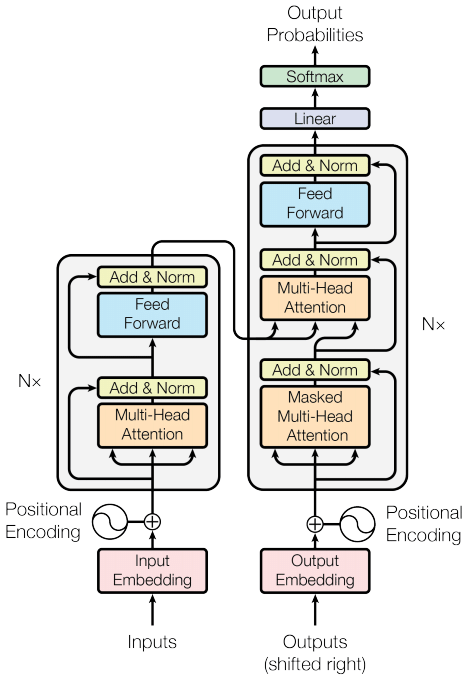

<center>Transformer Model Architecture (image source: https://arxiv.org/pdf/1706.03762.pdf)</center>


### Encoder-Decoder

The encoder consists of a stack of $N = 6$ identical layers, each containing two sub-layers, a multi-head self-attention layer, and a position-wise fully connected feed-forward network. Each sub-layer has a residual connection and layer normalization. Position-wise feed-forward network (FFN) consists of two linear transformations with ReLU activation in between. In FFN, the same linear transformation is applied across different positions. This can also be viewed as two convolutions with filter size 1.

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

The decoder is quite similar to the encoder, except that the decoder contains two multi-head self-attention layers instead of a single layer in a stack of $N = 6$ identical layers. The first multi-head self-attention layer attends to decoder outputs generated so far and is masked in order to prevent positions from attending to future positions, whereas the second multi-head self-attention layer attends over the encoder stack output.

The input and output sequences are embedded into a $d_{\text{model}}$ dimensional space, which is the usual step before feeding the sequence into the neural network. In addition, positional encoding is also applied to the embedded sequence, which gives a sense of order in the sequence. We'll discuss positional encoding in detail later.


### Self-Attention

Attention mechanisms proposed by [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf) and [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf) have been ubiquitously used to improve performance in various NLP tasks. As described previously that it is a mechanism that allows the neural network to make predictions by selectively focusing on a given sequence of data.

> *Self-attention, also known as intra-attention, is an attention mechanism relating different positions of a single sequence in order to compute a representation of the same sequence. It has been shown to be very useful in machine reading, abstractive summarization, or image description generation. (Excerpt from a [blog post](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) by Lilian Weng)*


Self-attention can be considered as a permutation invariant sequence-to-sequence operation where we map a query and a set of key-value pairs to an output. Here, the input and output in this self-attention operation are vectors. Thus, self-attention can be viewed as similar to the gating mechanism in LSTMs or GRUs, which decides how much information to store using different gates.


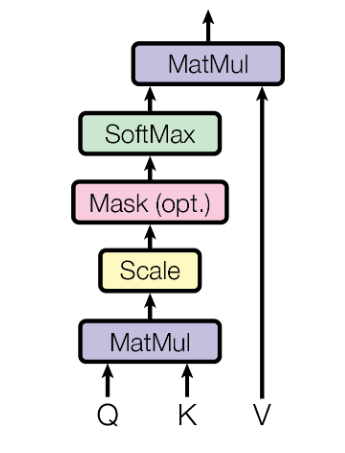

<center>Scaled Dot-Product Attention (image source: https://arxiv.org/pdf/1706.03762.pdf)</center>


The Transformer relies on "Scaled Dot-Product Attention" as a self-attention mechanism. Given a query matrix $Q$, a key matrix $K$, and a value matrix $V$, the output is a weighted sum of the values where the weight assigned to each value is determined by a dot product (compatibility function) of the query with the corresponding key. Mathematically, it can be expressed as follows:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V \\ 
\text{where}\ Q \in \mathbb{R}^{\mathrm{|Q|\times d_k}}, K \in \mathbb{R}^{\mathrm{|K|\times d_k}}, V \in \mathbb{R}^{\mathrm{|V|\times d_v}}
$$

The scaled dot-product attention faster and efficient since it is simply matrix multiplication. $\sqrt{d_k}$ is just a scaling or temperature factor which is used to normalize the dot-product in order to avoid uneven gradient flows. As we discussed above that, we perform the scaled dot-product attention on matrices due to efficient computations.

If we were to formulate the same expression using the query $q_i$, key $k_j$ , and value $v_j$ vectors, then it would be as follows:

$$
\text{Attention}(q_i, k_j, v_j) = \text{softmax}(\frac{q_i k_j^T}{\sqrt{d_k}}) v_j
$$

Visually, the scaled-dot product attention can be expressed as follows:


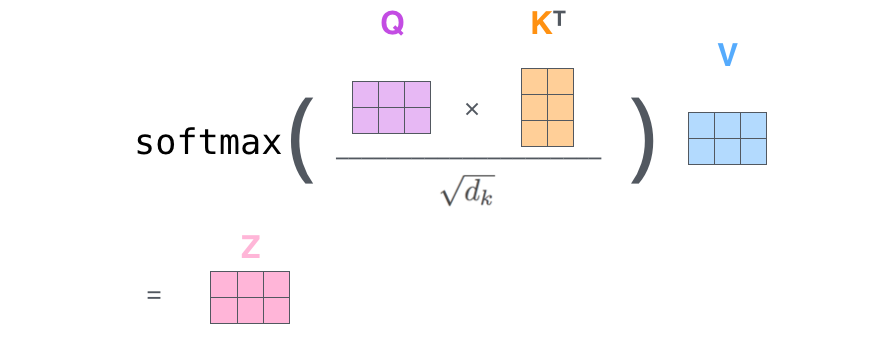

<center>Visual representation of self-attention calculation in matrix form (image source: https://jalammar.github.io/illustrated-transformer/)</center>


### Multi-Head Attention

Although it may seem that the single self-attention block is sufficient to capture all contextual relevance for a particular input word in the sequence, but in practice, the word may have multiple senses, which makes capturing complete context difficult. In order to solve the above issue, the authors introduced a multi-head attention mechanism which expands the model's ability to focus on different positions and allows to encode multiple relationships and nuances for a particular word in the sequence. In short, the multi-head attention mechanism is nothing but repeating scaled dot-product attention $h = 8$ times (i.e., over each subspace) in parallel.


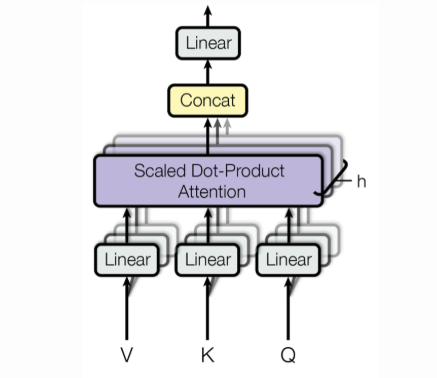

<center>Multi-Head Attention (image source: https://arxiv.org/pdf/1706.03762.pdf)</center>


> *According to the authors, multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.*


In the multi-head attention layer, the inputs query matrix $Q$, key matrix $K$, and a value matrix $V$ are first linearly transformed using weight matrices $W_i^Q$, $W_i^K$, $W_i^V$ for each attention head $i$. Then, the attention head outputs computed in parallel are concatenated and linearly transformed using weight matrix $W^O$.

Mathematically, it can be expressed as follows:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
W_i^Q \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^K \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^V \in \mathbb{R}^{\mathrm{
d_{model}\times d_v}}, W_i^O \in \mathbb{R}^{\mathrm{hd_v\times d_{model}}}
$$

Visually, the multi-head attention mechanism can be expressed as follows:

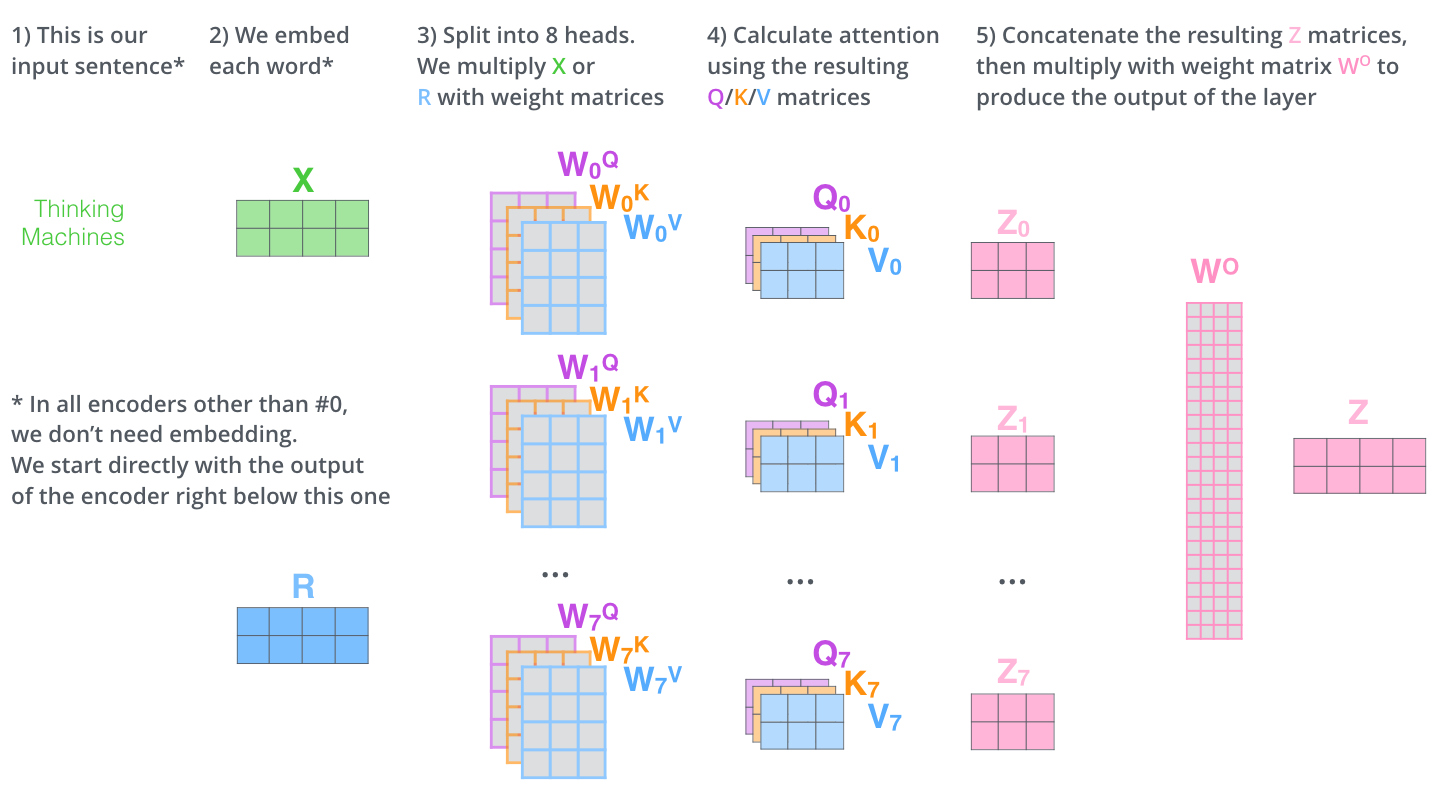

<center>Visual representation of multi-head calculation in matrix form (image source: https://jalammar.github.io/illustrated-transformer/)</center>


### Positional Encoding

As discussed above, the self-attention is permutation invariant, and we have ditched RNNs that inherently order the sequence during processing. Therefore, we need some way to incorporate position and order of sequence. In order to achieve the above, positional encoding was introduced, which adds positional information to each word in the sequence giving a sense of order.

A simple trivial solution would be to add index position to the word embeddings. However, there is a catch in the current solution that the word embedding values could get quite large for longer sequences and destroy the actual information in the embedding. Additionally, our model may not observe samples with specific lengths during training and result in poor generalization.

The authors proposed a sinusoidal positional encoding which is defined as follows:

$$
\begin{aligned}
    \text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
    \text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$

where $pos$ is the position and $i$ is the dimension.

Each dimension of the positional encoding corresponds to a sinusoid of different wavelengths in different dimensions ranging from $2\pi$ to $10000 \cdot 2\pi$.

Visually, the positional encoding can be expressed as follows:


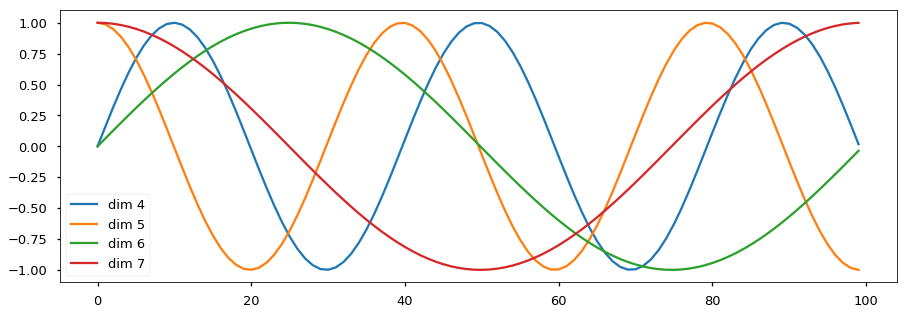

<center>Visual representation of positional encoding (image source: https://nlp.seas.harvard.edu/2018/04/03/attention.html)</center>


In the above diagram, we can observe that we may get the same position embedding values across different time steps for a particular dimension. For example, consider the curve dim 5 across time steps 20, 60, and 100. But if we consider curves from all the dimensions, we will end up getting different position embedding values across time steps. *(Please check [this post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) to learn more about positional encoding in the transformer.)*

You must be wondering that the positional encoding information will be lost as we process the embedded sequence in higher layers. How do we ensure that the positional information is preserved? Remember, we had used residual connections in each encoder and decoder layer. These residual connections help us carry positional information to higher layers.


Yay! we made it to the end. So let's highlight the motivation/benefits of the self-attention mechanism based on whatever we have discussed so far.

1. Computational complexity per layer is reduced due to the removal of recurrent layers
2. It is trivial to parallelize the amount of computations per layer
3. It provides us gating interactions observed similar to LSTMs and GRUs
4. Constant path lengths between any two positions in the sequence
5. It also helps in yielding more interpretable models due to multiple attention heads


# Follow-up Work

The Transformer proposed by Vaswani et al., 2017 was the first of its kind developed to process sequential data without using RNNs. Over the years, several state-of-the-art models have been derived based on the transformer architecture, and networks have become larger and larger due to the computational efficiency achieved compared to previously used RNNs. They are also now being applied to computer vision tasks described by [Han et al., 2021](https://arxiv.org/pdf/2012.12556.pdf).


## Transformer-XL

Although the transformer revolutionized natural language processing due to the self-attention mechanism, they have some limitations, such as fixed-length context and limited attention span. This means that model can only attend to the elements of a fixed-length segment leading to context fragmentation. Furthermore, this prevents the model from capturing long-term dependencies and allows no flow of the information across different segments.


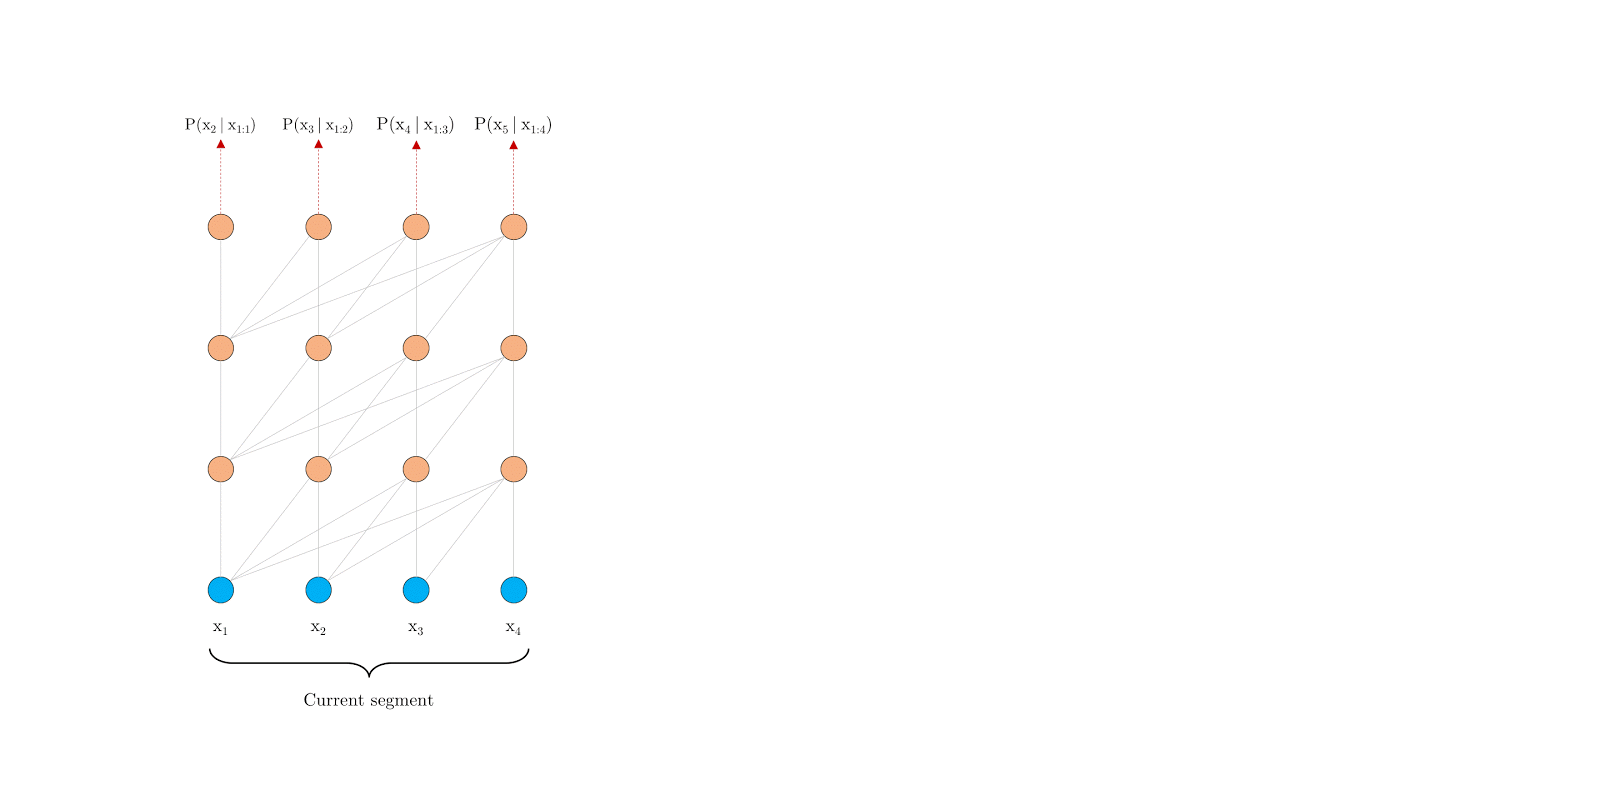

<center>Training phase of vanilla Transformer with a segment length 4 (image source: https://ai.googleblog.com/2019/01/transformer-xl-unleashing-potential-of.html)</center>


To overcome this issue, [Dai et al., 2019](https://arxiv.org/pdf/1901.02860.pdf) proposed Transformer-XL, which allows the flow of information by reusing hidden states between segments and enabling the ability to learn long-term dependencies.


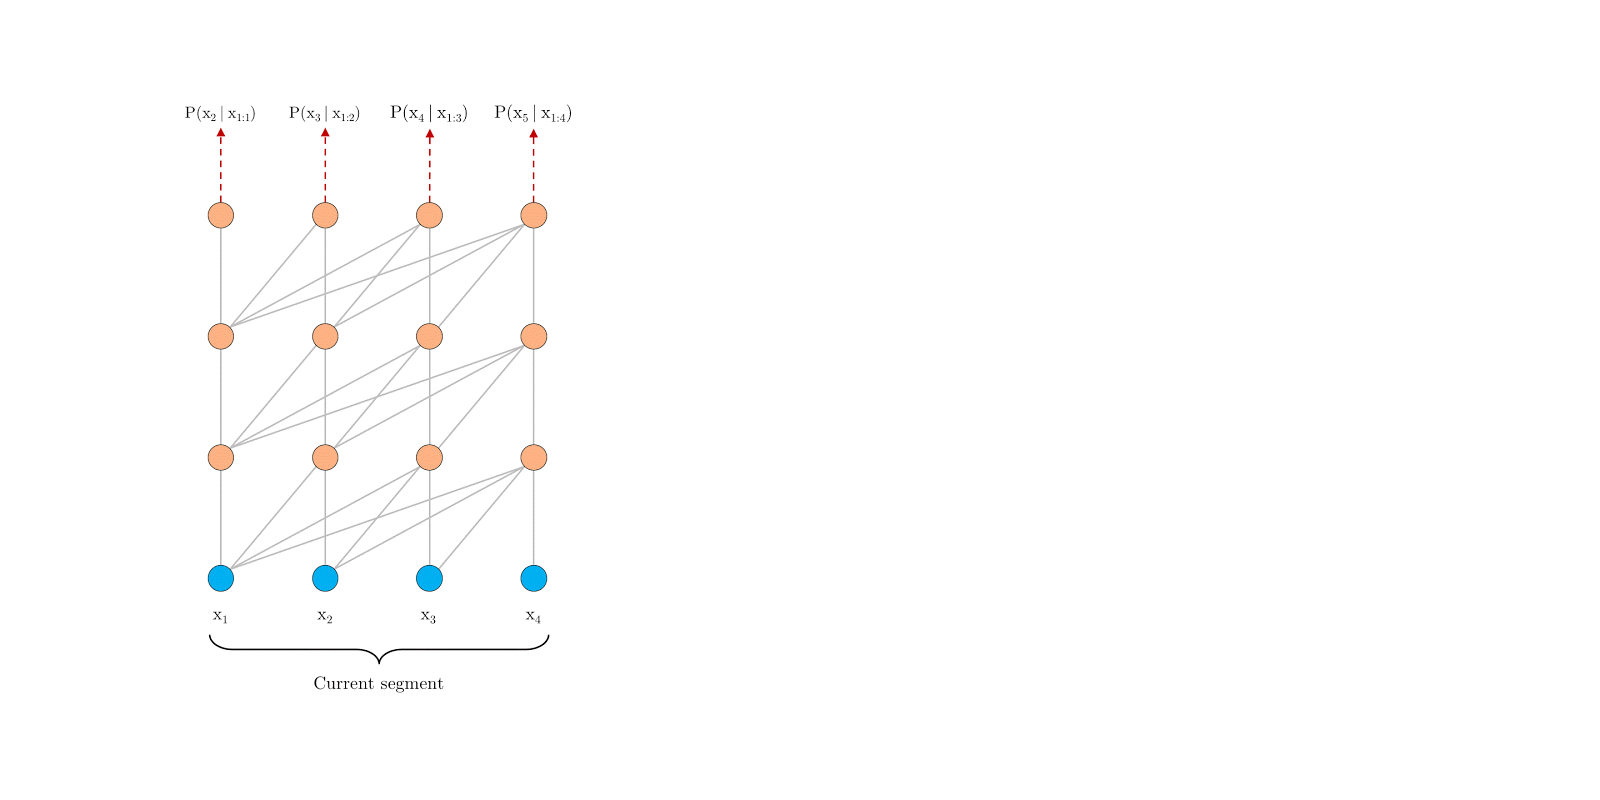

<center>Training phase of Transformer-XL with a segment length 4 (image source: https://ai.googleblog.com/2019/01/transformer-xl-unleashing-potential-of.html)</center>


## Reformer

The vanilla Transformer is very slow for processing long sequences since the self-attention takes $O(n^2)$ memory and computation where $n$ is the sequence length. Therefore, training these models is costly due to high memory and computation requirements. To overcome this limitation, [Kitaev et al., 2020](https://arxiv.org/pdf/2001.04451.pdf) proposed Reformer, a Transformer model designed to process long sequences efficiently without much memory and computation resource.

[Locality Sensitive Hashing (LSH)](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) is employed to reduce the complexity of attending over long sequences. The idea behind LSH is that similar items will end up in the same buckets with high probability. We use this idea for bucketing similar vectors instead of scanning over all the pairs of vectors. The vectors in the same bucket will only attend to each other during the self-attention computation. Additionally, they also use reversible residual layers instead of standard residuals, allowing more efficient use of memory since the activations are stored only once instead of $N$ times, where $N$ is the number of layers. This reduces the complexity from $O(n^2)$ to $O(n\ \text{log}\ n)$


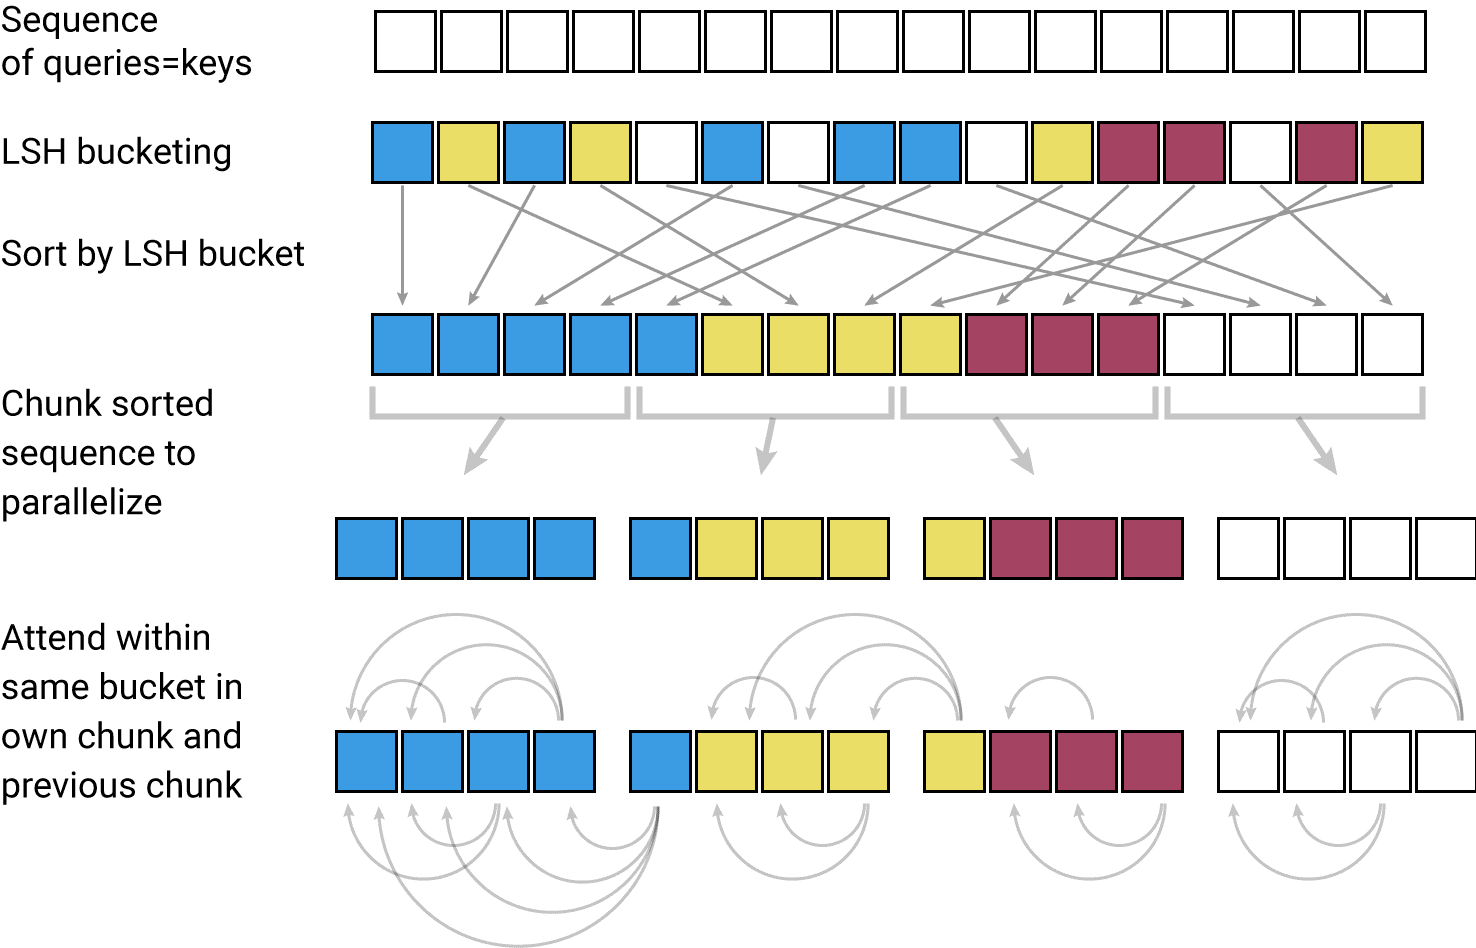

<center>Visual overview of LSH Attention (image source: https://arxiv.org/pdf/2001.04451.pdf)</center>


## Linear Transformers

This work also focuses on reducing the complexity of dot-product attention and draws a parallel between Transformers and RNNs. [Katharopoulos et al., 2020](https://arxiv.org/pdf/2006.16236.pdf) formulates the self-attention mechanism as a linear dot-product of kernel maps as follows:

$$
\text{Attention}(Q, K, V) = \frac{\sum_{j=1}^N \text{sim}(Q_i, K_j) V_j}{\sum_{j=1}^N \text{sim}(Q_i, K_j)}
$$

The above formulation is equivalent to the vanilla Transformer if we use the exponential dot-product as the similarity function.

$$
\text{sim}(Q, K) = \text{exp}(\frac{Q^T K}{\sqrt{d_k}})
$$

The authors propose to use kernel maps $\phi(x)$ to aggregate the information between all the elements in the sequence, thereby allowing us to compute the inner product between infinite-dimensional spaces efficiently. This new formulation leads to better memory and computation efficiency reducing the complexity from $O(n^2)$ to $O(n)$.

$$
V_i^\prime = \frac{\sum_{j=1}^N \phi(Q_i)^T \phi(K_j) V_j}{\sum_{j=1}^N \phi(Q_i)^T \phi(K_j)} = \frac{\phi(Q_i)^T \sum_{j=1}^N  \phi(K_j) V_j}{\phi(Q_i)^T \sum_{j=1}^N \phi(K_j)}
$$

The above equation in the vectorized form is as follows:

$$
(\phi(Q)\ \phi(K)^T)\ V = \phi(Q)\ (\phi(K)^T\ V)
$$

Although the vanilla Transformers perform better than the linear Transformers, but there is a significant improvement in speed for linear Transformers. The authors have also provided a demo which you can play with at this [link](https://linear-transformers.com/).


There are many follow-up works based on the vanilla Transformer architecture. Unfortunately, it is not possible to highlight every piece of work in this blog. Instead, I have tried to give intuition behind the few architectures above. I would definitely advise you to check the following [webpage](https://paperswithcode.com/methods/category/transformers) to explore other transformer architectures as well as read the survey paper by [Lin et al., 2021](https://arxiv.org/pdf/2106.04554.pdf).

If you would like to play around with the vanilla Transformer, here is the [colab notebook](https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Attention%20Is%20All%20You%20Need.ipynb) created by me for English to German translation.


# References

1. [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
2. [Łukasz Kaiser’s talk on Attentional Neural Network](https://www.youtube.com/watch?v=rBCqOTEfxvg)
3. [Transformer: A Novel Neural Network Architecture for Language Understanding by Google AI](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)
4. [The Illustrated Transformer by Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
5. [The Annotated Transformer by Harvard NLP Group](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
6. [Attention? Attention! by Lilian Weng](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
7. [What is the positional encoding in the transformer model?](https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model)
8. [Transformer Architecture: The Positional Encoding by Kazemnejad](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
9. [Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context](https://arxiv.org/pdf/1901.02860.pdf)
10. [Transformer-XL: Unleashing the Potential of Attention Models by Google AI](https://ai.googleblog.com/2019/01/transformer-xl-unleashing-potential-of.html)
11. [Reformer: The Efficient Transformer](https://arxiv.org/pdf/2001.04451.pdf)
12. [Reformer: The Efficient Transformer by Google AI](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
13. [Transformers are RNNs: Fast Autoregressive Transformers with Linear Attention](https://arxiv.org/pdf/2006.16236.pdf)
